# Getting Started With Robot Inverse Kinematics (IK)

Welcome to the first guide in the series of getting started with Dr.QP robot Inverse Kinematics (IK).
In this guide, we will cover the basics of IK and how to use it to control a robot.

## What is Inverse Kinematics?
Inverse Kinematics (IK) is a technique used in robotics to determine the joint angles required to achieve a desired end-effector position. It is the process of solving the inverse problem of forward kinematics, which calculates the end-effector position given the joint angles.

## Why is Inverse Kinematics Important?
Inverse Kinematics is important because it allows robots to perform complex movements and tasks. By calculating the joint angles required to reach a specific position, robots can navigate their environment and interact with objects more effectively.

## How to Use Inverse Kinematics
To use Inverse Kinematics, you need to have a model of your robot's kinematics. This model includes the lengths of the robot's links and the joint angles. Once you have this model, you can use it to calculate the joint angles required to achieve a desired end-effector position.

## The robot model

For this tutorial we will use the simplest part of Dr.QP robot - a single leg.
It has a 3 degrees of freedom and consists of 3 links: coxa, femur and tibia and 3 joints: alpha, beta and gamma.

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
coxa_length = 2
femur_length = 4
tibia_length = 7

alpha = 0 # controls coxa angle, 0 is straight
beta = 0 # controls femur angle, 0 is straight
gamma = 0 # controls tibia angle, 0 is straight



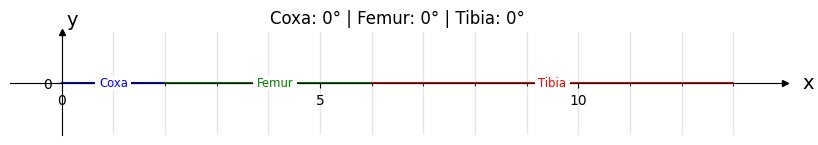

In [15]:
import numpy as np
from inline_labels import add_inline_labels

class Point:
    """A simple 2D point class to make math less verbose"""
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __repr__(self):
        return f"Point({self.x}, {self.y})"

    def __add__(self, other):
        return Point(self.x + other.x, self.y + other.y)

    def __sub__(self, other):
        return Point(self.x - other.x, self.y - other.y)

    def __mul__(self, other):
        return Point(self.x * other, self.y * other)

    # cast to numpy array
    def __array__(self):
        return np.array([self.x, self.y])

    def rotate(self, angle):
        x = self.x * np.cos(angle) - self.y * np.sin(angle)
        y = self.x * np.sin(angle) + self.y * np.cos(angle)
        return Point(x, y)


def forward_kinematics(coxa_length, femur_length, tibia_length, alpha, beta, gamma):
    alpha_rad = np.radians(alpha)
    beta_rad = np.radians(beta) + alpha_rad
    gamma_rad = np.radians(gamma) + beta_rad


    start = Point(0, 0)
    coxa = start + Point(coxa_length, 0).rotate(alpha_rad)
    femur = coxa + Point(femur_length, 0).rotate(beta_rad)
    tibia = femur + Point(tibia_length, 0).rotate(gamma_rad)

    return [start, coxa, femur, tibia]

# Plot the leg links in 2D space
def plot_leg_links(axes, coxa, femur, tibia, alpha, beta, gamma):
    # Calculate the coordinates of the leg links
    points = forward_kinematics(coxa, femur, tibia, alpha, beta, gamma)
    colors = ['b-', 'g-', 'r-']
    labels = ['Coxa', 'Femur', 'Tibia']

    last_point = points[0]
    for point, color, label in zip(points[1:], colors, labels):
        axes.plot([last_point.x, point.x], [last_point.y, point.y], color, label=label)
        last_point = point

    add_inline_labels(axes, with_overall_progress=False, fontsize="small")

    return np.array([p.x for p in points]), np.array([p.y for p in points])

def plot_leg_links_at_angles(alpha, beta, gamma):

  _, ax = plt.subplots(figsize=(10, 10))
  ax.set_title(f'Coxa: {alpha}° | Femur: {beta}° | Tibia: {gamma}°')

  x, y = plot_leg_links(ax, coxa_length, femur_length, tibia_length, alpha, beta, gamma)

  # Select length of axes and the space between tick labels
  xmin, xmax = np.min(x), np.max(x)
  ymin, ymax = np.min(y), np.max(y)
  ticks_frequency = 5

  # Set identical scales for both axes
  ax.set(xlim=(xmin-1, xmax+1), ylim=(ymin-1, ymax+1), aspect='equal')

  # Set bottom and left spines as x and y axes of coordinate system
  ax.spines['bottom'].set_position('zero')
  ax.spines['left'].set_position('zero')

  # Remove top and right spines
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

  # Create 'x' and 'y' labels placed at the end of the axes
  ax.set_xlabel('x', size=14, labelpad=-24, x=1.03)
  ax.set_ylabel('y', size=14, labelpad=-21, y=1.02, rotation=0)

  # Create custom major ticks to determine position of tick labels
  x_ticks = np.arange(xmin, xmax+1, ticks_frequency)
  y_ticks = np.arange(ymin, ymax+1, ticks_frequency)
  ax.set_xticks(x_ticks)
  ax.set_yticks(y_ticks)

  # Create minor ticks placed at each integer to enable drawing of minor grid
  # lines: note that this has no effect in this example with ticks_frequency=1
  ax.set_xticks(np.arange(xmin, xmax+1), minor=True)
  ax.set_yticks(np.arange(ymin, ymax+1), minor=True)

  # Draw major and minor grid lines
  ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)

  # Draw arrows
  arrow_fmt = dict(markersize=4, color='black', clip_on=False)
  ax.plot((1), (0), marker='>', transform=ax.get_yaxis_transform(), **arrow_fmt)
  ax.plot((0), (1), marker='^', transform=ax.get_xaxis_transform(), **arrow_fmt)

plot_leg_links_at_angles(0, 0, 0)

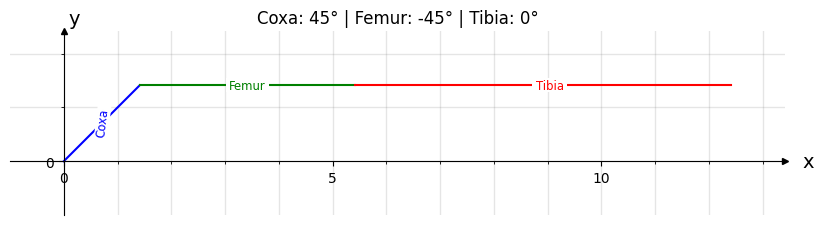

In [16]:

plot_leg_links_at_angles(45, -45, 0)

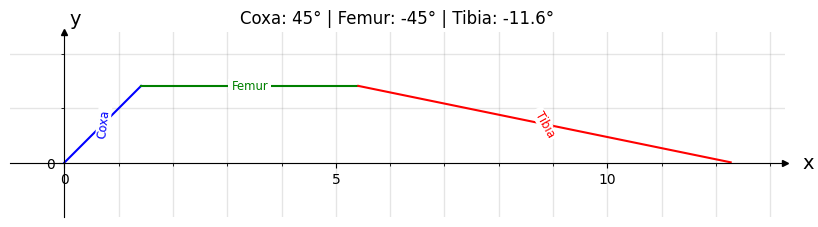

In [17]:
plot_leg_links_at_angles(45, -45, -11.6)